# Context

## Quick reminder on last course

XX

## Goal of this course

XX


# Concepts

## Model Evaluation

For regressors, the evaluation of the model is less straightforward and id usually based upon the average residual between the actual data and the model predictions. __Root mean squared error__ (RMSE) and __mean absolute error__ (MAE) are two commonly used examples of these. Once we have a representation of the error produced by the model we can compare that error with the error of the most simple model of the data (usually the mean). This statistic is known as the coefficient of determination or __R-squared__ and represents the part of variability the model managed to get.

# Regression

The first thing to do is to get our data back.

In [22]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
# We put both target arrays (regression and classification) in the same txt file
# As both target arrays have the same size we just need to split it it two
# and get the correct part for the prediction task
target = np.split(np.loadtxt('target.txt'), 2)[0].flatten()
features = pd.read_csv('features.csv')

# User id as index
features = features.set_index('user_id')

In [3]:
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,total_watched,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,16.831750,...,1,0,0,0,0,0,0,1,0,0
000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,488.301100,...,0,0,1,0,0,0,0,0,1,0
001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.489419,3,3.176167,...,0,1,0,0,0,0,0,0,1,0
001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,14.795717,...,0,0,0,0,0,1,0,0,1,0
002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.228233,17,291.477033,...,0,1,0,0,0,0,0,1,0,0


In [4]:
target[:10]

array([  1.44833333e-01,   3.18047633e+02,   1.98035000e+00,
         1.00590667e+01,   0.00000000e+00,   4.79261667e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

## Baseline forecasts

As mentionned before we should have a baseline to compare the performance of our models with. Here as we are forecasting a quantitative variable, a simple model is for example the one that predicts a constant value like the mean or the median we can observe on our past data. 

Note as well that by default `scikit` maximises metrics during gridsearch etc. Error metrics have been implemented as a negative number within the scoring function even if that is different to the usual. We therefore negate the baseline numbers to make them comparable and look for those models that maximise this number.

In [5]:
# Create a baseline to compare our results to (mean and median minutes watched and 0)
mean=np.mean(target)
median=np.median(target)

mean_forecast=[mean]*len(target)
median_forecast=[median]*len(target)
zero_forecast=[0]*len(target)

In [6]:
print("Mean: "+str(mean))
print("Median: "+str(median))

Mean: 75.9168097123
Median: 0.0


We have lots of 0s in our target, so lots of user who don't come back on iPlayer for the last two weeks.

In [7]:
# Compute the errors for these different baseline
from sklearn import metrics
print("Score if we forecast the mean:",
      -metrics.mean_absolute_error(target,mean_forecast))
print("Score if we forecast the median:",
      -metrics.mean_absolute_error(target,median_forecast))
print("Score if we forecast zero:",
      -metrics.mean_absolute_error(target,zero_forecast))

Score if we forecast the mean: -115.319756974
Score if we forecast the median: -75.9168097123
Score if we forecast zero: -75.9168097123


## Linear Regression

`scikit learn` documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [10]:
# Let's build a simple regression
from sklearn import linear_model

# We will use cross validation, so import helper functions for this
from sklearn.model_selection import cross_val_score, cross_val_predict

### Model training

We don't have any hyperparameter to tune here. 

The `cross_val_predicts` functions here returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. 

In [17]:
# We setup a simple linear regression, again using cross validation
reg=linear_model.LinearRegression()

predicted=cross_val_predict(reg, features,target)
scores=cross_val_score(reg, features, target, scoring='neg_mean_absolute_error')

### Out-of-sample errors

In [18]:
# Compute the mean error obtained in the CV
print("Mean score:", np.mean(scores))

Mean score: -59.5686984499


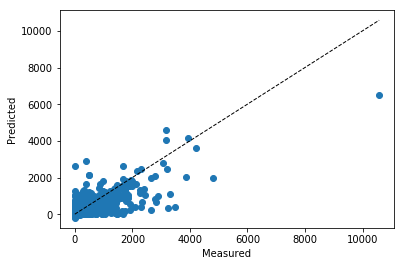

In [25]:
# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## In-sample errors (training on _all_ data)

In [42]:
# Let's train on all data 
lin_reg=linear_model.LinearRegression()
mod1=lin_reg.fit(features,target)

In [47]:
# In-sample error
from sklearn.metrics import mean_absolute_error
-metrics.mean_absolute_error(target,mod1.predict(features))

-56.937271915356376

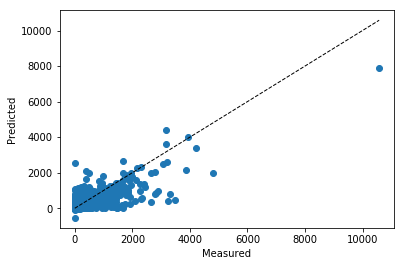

In [48]:
# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, mod1.predict(features))
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

__COMMENTS__

## Ridge Regression

__DETAILS __

`scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### Model training and hyperparameters tuning

We need to tune the penalty parameter _alpha_. Let's have the same approach than for the classification part and do a grid search.

In [28]:
# Setup the model and develop a simple grid search against some key parameters
param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [32]:
# Let's keep track of our best parameters
best_score=-200
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_alpha:
    reg_r = linear_model.Ridge(alpha = i)
    scores=cross_val_score(reg_r,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    if np.mean(scores)>best_score:
        best_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: alpha:',best_param)
print('Score:', best_score)

Best Settings: alpha: 100
Score: -57.7098244083


__COMMENTS__

### Best ridge regression

In [49]:
# Let's keep our best model (hyperparameters tuned)
ridge=linear_model.Ridge(alpha = best_param)
mod2=ridge.fit(features,target)

In [51]:
# In-sample error
-metrics.mean_absolute_error(target,mod2.predict(features))

-56.392707025240128

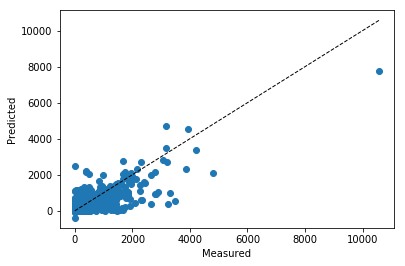

In [52]:
# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, mod2.predict(features))
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

__COMMENTS__

## Lasso Regression

__DETAILS __

`scikit documentation`: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

### Model training and hyperparameters tuning

Again we need to tune the penalty parameter _alpha_.

In [53]:
# Setup the model and develop a simple grid search against some key parameters
param_alpha=[0.001,0.01,0.1,1.0,10,100]

In [54]:
# Let's keep track of our best parameters
best_score=-200
best_param=0

# we will setup a manual grid search, but you can also use the gridsearchCV capability in sklearn
for i in param_alpha:
    reg_r = linear_model.LassoLars(alpha = i)
    scores=cross_val_score(reg_r,
                           features,
                           target,
                           scoring='neg_mean_absolute_error')
    if np.mean(scores)>best_score:
        best_score=np.mean(scores)
        best_param=i

# print the overall best results
print('Best Settings: alpha:',best_param)
print('Score:', best_score)

Best Settings: alpha: 0.1
Score: -56.3843647323


__COMMENTS__

### Best lasso regression

In [55]:
# Let's keep our best model (hyperparameters tuned)
lasso=linear_model.LassoLars(alpha = best_param)
mod3=lasso.fit(features,target)

In [56]:
# In-sample error
-metrics.mean_absolute_error(target,mod3.predict(features))

-55.780781090183837

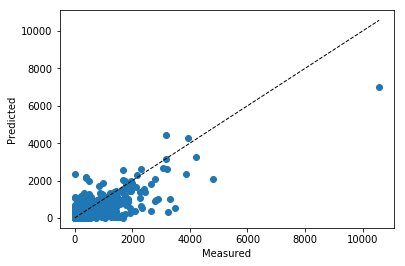

In [57]:
# Let's compare graphically the predicted and actual values
fig, ax = plt.subplots()
ax.scatter(target, mod3.predict(features))
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

__COMMENTS__

## Combine the regression and classification models and generate an overall score 
